# Auto Stability Analysis for Material Degradation Studies
<div>
<img src="./data/automated_degradation_R3.png" align = "center" width="500" />
</div>
This code utilizes several computer vision techniques to quickly extract and analyse accurate color vs time data of multiple chemical compounds printed using a high-throughput Multi-Material Deposition (MMD) system. The stability analysis consists of two parts: color calibration and instability indices calculation. The first part involves color calibrating the input images with a reference set of colors to improve the fidelity of the coloremetric data. The second part involves calculating an instability index to quantify the change in color of each material over time. 

#### Part 1: Color Calibration 
- Section 1: Cropping and Droplet Segmentation 
- Section 2: Saves all results of droplet segmentation including image cropping parameters and droplet IDs
- Section 3: Outputs Color Calibrated Data of Droplets Color Over Time 
#### Part 2: Instability Index Calculation  
- Section 1: Composition Extraction  
- Section 2: Extract Instability Indices 
- Section 3: Make Relevant Figures 

In [1]:
import cv2
from PIL import Image
from scipy import signal,ndimage
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import openpyxl 
import pickle
import pandas as pd
import os as os
import tiffile as tif
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
import numpy.matlib as matlib
import colorfunctions
from colorfunctions import Sample
from colorfunctions import crop_box, RRC, segment_on_dt, water, time_names_0, output_for_labeling, cc_crop
from colorfunctions import CC_RGB, convert_LAB_RGB, color_calibration, Results
import matplotlib.patches as patches 
import compextractor
import matplotlib.animation as animation
from colorfunctions import point_ave,Edge_detect,warp_image,clean_warp
import mainfunctions
import requests

### Section 1: Droplet Segmentation 
- Unwrap the tiff files and save the images individually in the folder Images_simp
- Crop the image chosen for droplet segmentation to center on the samples. The substrate (glass slide) must be included in the croped image.


In [2]:
# Download the Tiff files from osf 
# Note: Batch 1 and 3 are best, batch 2 requires changing segmentation parameters * 
batch_num = 1 
codes = {
    'deg01':'hwugb',
    'deg11': 'bdyzs',
    'x1' : 'd5knw',
    'deg02': 'fwmnc',
    'deg12': 'wdzj5',
    'x2' : 'sjm7u',
    'deg03': '64ekp',
    'deg13': '3zj8e',
    'x3' : 'r3fj2'
}

# Batch 1 (AF_D20230724_H1630_MAFA_T150_FS_AS)
mainfunctions.download('tif',url=f"https://osf.io/download/{codes[f'deg0{batch_num}']}",filename='MAFA_deg_0.tif')
mainfunctions.download('tif',url=f"https://osf.io/download/{codes[f'deg1{batch_num}']}",filename='MAFA_deg_1.tif')
mainfunctions.download('xrite',url=f"https://osf.io/download/{codes[f'x{batch_num}']}",filename='xrite.png')

# turn png to jpg 
mainfunctions.png_to_jpg('./Images_simp/xrite.png','./Images_simp/xrite.jpg')
# Reads'sample_names' csv file with information about the experiment 
sheet_obj, Sample_ID, Notes, Time_Step, pixel_to_length, start_image, cut, start_comp, num_pics,time,name,img_name = mainfunctions.unwrap_tiff()


data/MAFA_deg_0.tif downloaded: 641.309 MB
data/MAFA_deg_1.tif downloaded: 284.173 MB
data/xrite.png downloaded: 2.035 MB
Image './Images_simp/xrite.png' converted to './Images_simp/xrite.jpg'


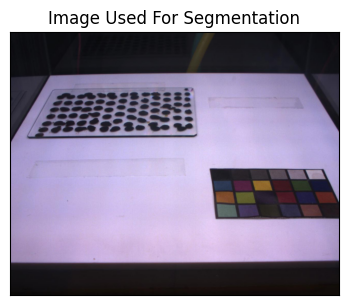

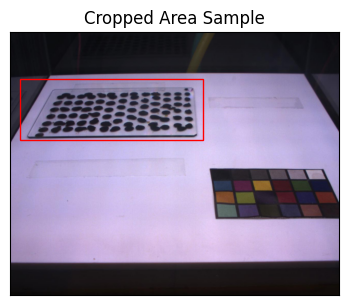

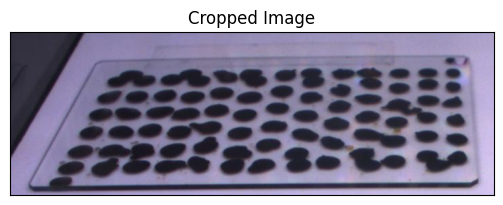

In [3]:
img_path, im = mainfunctions.show_cal_image(img_name,verbose=True)
# These xvals and yvals are crop indices for the min and max x value and the min and max y vals respectively
    # Change xvals and yvals to fit the red box around the area to be cropped (should include the glass slide only)
    # Display the Crop Box as a red rectangle over the image
image_crop_params = {
    'xvals': [40,750],
    'yvals': [180,420]
} 
crop_image, crop_image_pil,crop_params = mainfunctions.crop_im(im, image_crop_params, img_path,verbose=True)

### Segment Droplets 
- Segment droplets 
- Erode the droplets to get rid of their edges. The larger the kernel value to more of the edges are removed (User sets kernel [k] parameter value. Default value is 6). The glass slide should disappear in this step. 
- Superimposes the segmented droplets onto the original image to serve as a visual check for the droplet segmentation, it is the final step of droplet Segmentation

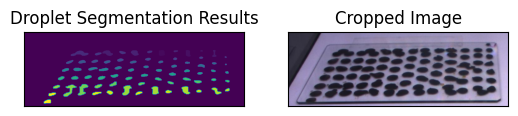

In [4]:
# Define the maximum and minimum pixel size of droplets
# Any segmented samples outside this sample range will be deleted 
# Note: if batch is 2, set ks to 15*
seg_params = {
    'large_elements_pixels': 1000, # Define the maximum and minimum pixel size of droplets
    'small_elements_pixels': 0,    # Any segmented samples outside this sample range will be deleted
    'ks' : 11, #11,12,13 ks is the kernel value for dilating the image, enlagring ks reduces clustered droplets 
} 

droplet_count = mainfunctions.segment(crop_image,seg_params,verbose=True)

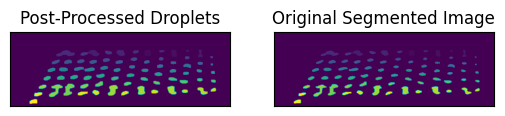

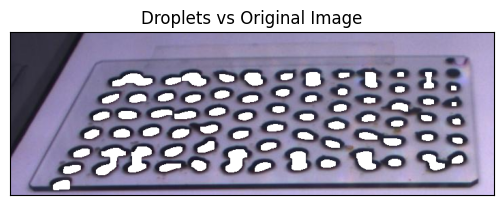

In [5]:
clean_params= {
    'k' : 1, # k = erode kernel to remove noise 
    'kd': 3 # kd = dilate kernel to enlarge segmented droplets 
} 
img_erode,crop_image_erode, PIL_crop_image_erode= mainfunctions.clean(clean_params, seg_params, droplet_count,crop_image,crop_image_pil,verbose=True) 

#### Crop and set indices for the colors on the Xrite color reference cards 
x_vals, yvals are the x and y range of the total crop area, wid and hei are the crop box width and heights, the values a,b,c, and d can also be changed for more flexibility in aligning the boxes. 

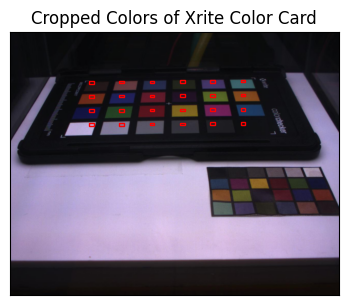

In [7]:
xrite_crop_params = {
    'xvals': [308,980], # [X lower bound, X upper bound]
    'yvals': [340,190], # [Y Lower bound, Y upper bound] 200,190,185
    'wid_x': 18, # Width of Crop boxes 
    'hei_x': 10, # height of Crop boxes
    'a': 100, #108 spacex
    'b': 45,  #40 spacey
    'c': 0,   # offsetx
    'd': -1   # offsety
}
xc_ll_x,xc_ll_y = mainfunctions.get_xrite(xrite_crop_params,verbose=True)

### Section 2: Droplet Labeling 
A function that takes in droplet matrices, segregates and counts droplets, creates a class called sample and finally saves the matrices using pickle.

In [8]:
sample = output_for_labeling(crop_params, crop_image_pil, img_erode,Sample_ID, droplet_count, crop_image_erode, PIL_crop_image_erode, img_name, Notes, pixel_to_length )

Saved sample data


### Section 3: Callibrate Sample Colors 

At the beginning of the degradation study, an image of a reference color chart (X-Rite Colour Checker Passport; 28 reference color patches), $I_R$, is taken under the same illumination conditions as the perovskite semiconductor samples. Images at each time step, $\Omega (\Delta t)$, are transformed into L*a*b color space and subsequently to a stable reference color space (standard observer CIE 1931 2 degrees, standard illuminant D50) by applying a 3D-thin plate spline distortion matrix $D$ defined by $I_R$ and known colors of the reference color chart:

\begin{equation}
    \label{eq:4}
    D= \begin{bmatrix}
    V\\
    O(4,3)
    \end{bmatrix}{\begin{bmatrix}
    K & P \\
    P^T & O(4,4)
    \end{bmatrix}}^{-1}
\end{equation}


 Here, $O(n,m)$ is an $n$x$m$ zero matrix, $V$ is a matrix of the color checker reference colors in the stable reference color space, $P$ is a matrix of the color checker RGB colors obtained from $I_R$, and $K$ is a distortion matrix between the color checker colors in the reference space and in $I_R$. Using the color-calibrated images and droplet pixel locations given by $\Phi$, a final array, $R(t; \widehat{X}, \widehat{Y})$ of the average color at time $t$ for perovskite semiconductor of composition FA$_{1-x}$MA$_x$PbI$_3$ is created. The color of each droplet is measured to determine a stability metric $I_c$.  

Now Lets Run Color Calibration on the Droplets and Create Calibrated RGB values over time for each droplet

In [9]:
RGB_result, LAB_result, CC_result, sample_result, WA_result = Results(xc_ll_x,xc_ll_y,xrite_crop_params['wid_x'],xrite_crop_params['hei_x'],sample.crop_params,num_pics,time,name,start_image,verbose=True)
pickle.dump(RGB_result, open('./Results/RGB_results_f','wb'))

DONE 1/240
DONE 2/240
DONE 3/240
DONE 4/240
DONE 5/240
DONE 6/240
DONE 7/240
DONE 8/240
DONE 9/240
DONE 10/240
DONE 11/240
DONE 12/240
DONE 13/240
DONE 14/240
DONE 15/240
DONE 16/240
DONE 17/240
DONE 18/240
DONE 19/240
DONE 20/240
DONE 21/240
DONE 22/240
DONE 23/240
DONE 24/240
DONE 25/240
DONE 26/240
DONE 27/240
DONE 28/240
DONE 29/240
DONE 30/240
DONE 31/240
DONE 32/240
DONE 33/240
DONE 34/240
DONE 35/240
DONE 36/240
DONE 37/240
DONE 38/240
DONE 39/240
DONE 40/240
DONE 41/240
DONE 42/240
DONE 43/240
DONE 44/240
DONE 45/240
DONE 46/240
DONE 47/240
DONE 48/240
DONE 49/240
DONE 50/240
DONE 51/240
DONE 52/240
DONE 53/240
DONE 54/240
DONE 55/240
DONE 56/240
DONE 57/240
DONE 58/240
DONE 59/240
DONE 60/240
DONE 61/240
DONE 62/240
DONE 63/240
DONE 64/240
DONE 65/240
DONE 66/240
DONE 67/240
DONE 68/240
DONE 69/240
DONE 70/240
DONE 71/240
DONE 72/240
DONE 73/240
DONE 74/240
DONE 75/240
DONE 76/240
DONE 77/240
DONE 78/240
DONE 79/240
DONE 80/240
DONE 81/240
DONE 82/240
DONE 83/240
DONE 84/240
D

## Part 2: Data Analysis
<div>
<img src="./data/extracted_stability_trend_and_samples_R1.png" align = "center" width="500" />
</div>
This part starts will loading all the color calibrated images and variables. This allows the user to analyze data that has previously been color calibrated and reload parameters for data that has already been analysed. 

In [10]:
RGB_result, Number_of_drops, num_pics, time,name,drops,droplet_count0,drop_IDs,img_erode,crop_params,start_comp,end_comp,sample_ID,already_processed,cv_params,extract_params = mainfunctions.load_pick()
RGB_result = np.floor(RGB_result).astype(int)

### Section 1: Composition Extraction

#### Detect Substrate and Warp Images for Composition Extraction 

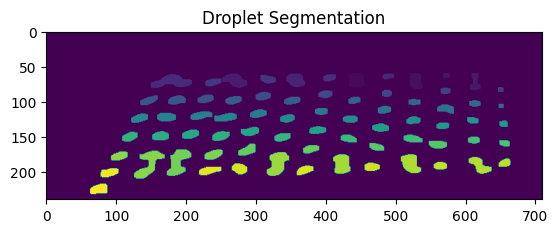

C:\Users\eunic\Auto_Stability\colorfunctions.py:785: RuntimeWarning: divide by zero encountered in double_scalars
  pts_x[i,j] = (B[j]-B[i])/(M[i]-M[j])
C:\Users\eunic\Auto_Stability\colorfunctions.py:786: RuntimeWarning: invalid value encountered in double_scalars
  pts_y[i,j] = M[i]*pts_x[i,j] + B[i]


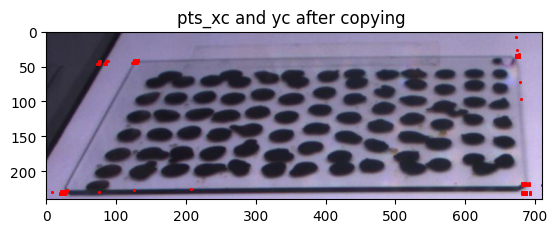

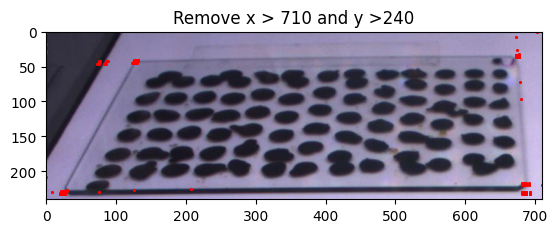

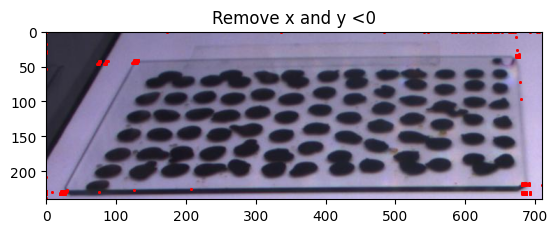

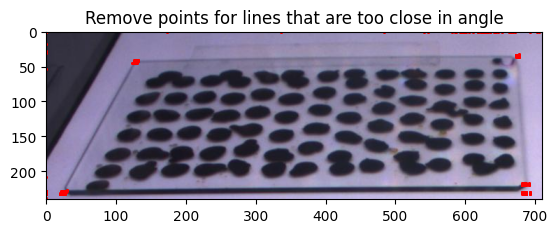

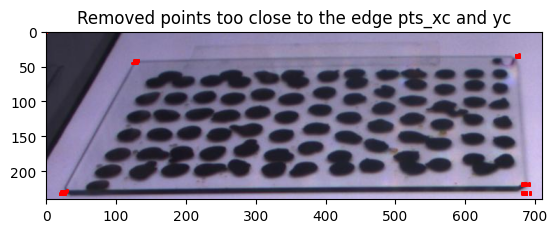

C:\Users\eunic\Auto_Stability\colorfunctions.py:1042: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pt_s not in np.unique(pt_xys):


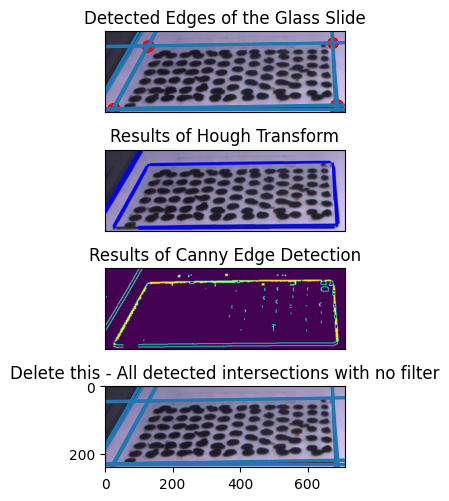

Indices = all poins that are too close to each other
[[  0.   6.]
 [  0.   8.]
 [  0.   9.]
 ...
 [163. 156.]
 [163. 157.]
 [163. 161.]]
Alone
[]
Cl_pts = repeats are removed
['06' '08' '09' ... '159162' '160162' '161163']
cl_pts_num = cl_pts but as numbers
[[  0.   6.]
 [  0.   8.]
 [  0.   9.]
 ...
 [159. 162.]
 [160. 162.]
 [161. 163.]]
Final cor after Removing repeats to find true corners
[[128.1564695   43.95991693]
 [674.25487804  33.80938889]
 [ 23.61189643 227.50510662]
 [687.43051457 218.77065113]]
Final Corners after re-adding points that were all alone
[[128.1564695   43.95991693]
 [674.25487804  33.80938889]
 [ 23.61189643 227.50510662]
 [687.43051457 218.77065113]]
Found Corners


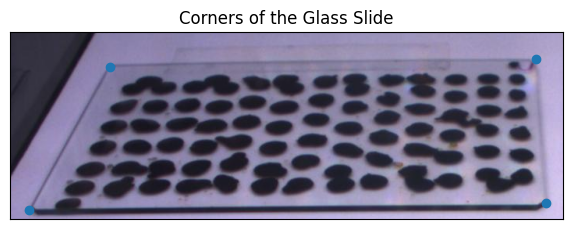

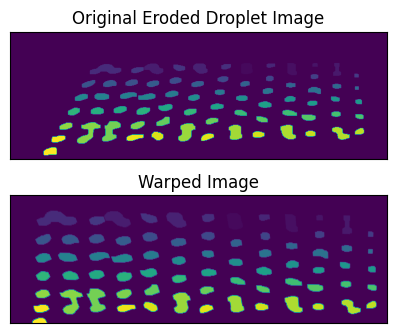

In [11]:
# For more explanation on there parameters see : https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb
# linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, ts, None, srn,stn)
detect_params = {
        'k' : 5, # kernel size for erode and dilating the original image to get rid of image noise  
        'ap_size' : 3, # these variable are for cv2.Canny(imgray, lb, ub,apertureSize=ap_size)
        'lb' : 30,
        'ub' : 100,  
        'c' : 4, # c value for adaptive tresholding
        'block' : 21, # block size for adaptive tresholding
        'ts' : 42, # 42 Accumulator threshold parameter. Only those lines are returned that get enough votes ( >threshold ).
        'srn' : 100, # was 140, interesting at 100 minimum line length -Minimum length of line. Line segments shorter than this are rejected.
        'stn' : 11, # 11 maxline gap -Maximum allowed gap between line segments to treat them as single line.
        'min_dis' : 50, # Getting rid of points that are too close to each other 
        'ang_min' :60.0, # 60.0min angle between lines to be considered an edge 
        'k_del' : 20,
        'k_edge' : 5,
        'k_edge_er' : 4

}
crop_image, corners,cv_params = mainfunctions.main_edge_detect(img_erode,name,crop_params,cv_params,already_processed,detect_params,verbose=True)
warp,final_warp,deconst_warp,warp_clean2 = mainfunctions.main_warp(corners,crop_image,img_erode,drop_IDs,Number_of_drops,verbose=True)

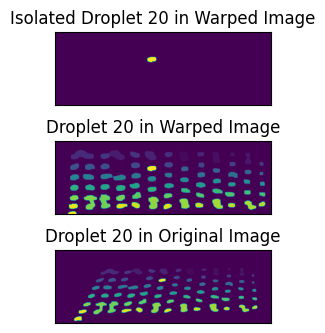

In [12]:
# Check Image warped properly
drop_index = {
    'warp_id' : 20, # Droplet in the warped image 
    'og_id' : 20 # Droplet in the original Image 
}
mainfunctions.warp_check(drop_index, final_warp, img_erode, drop_IDs, verbose=True)

#### Composition extractor 

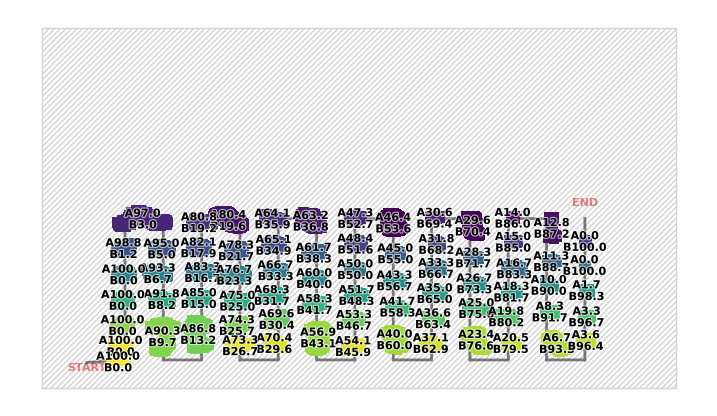

MovieWriter ffmpeg unavailable; using Pillow instead.


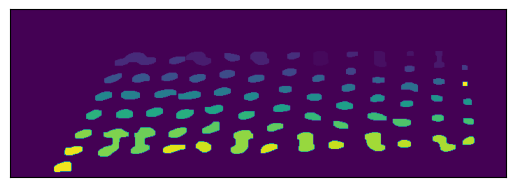

In [13]:
comp_params = {
    'rasterSpeed' : 38, # mm/s gocde raster speed
    'rasterScaleY' :  0.8, # scale gcode raster pattern in Y-dim
    'rasterScaleX' : 0.935, # scale gcode raster pattern in X-dim
    'rasterOffsetY' : 4, # offset gcode raster pattern in X-dim
    'rasterOffsetX' : 15 # offset gcode raster pattern in X-dim
} 
extract_params, order, comp = mainfunctions.main_comp(comp_params,already_processed,final_warp,extract_params,verbose=True)
mainfunctions.order_check(Number_of_drops,img_erode,order,verbose=True)

### Section 2: Extract Instability Indices

We compute the degradation intensity, $I_c$, of each HT-manufactured perovskite composition by integrating the change in color, $R$, in each sample over time, $t$:
\begin{equation}
    \label{eq:5}
    I_c(\widehat{X},\widehat{Y})= \sum_{R = \{r,g,b\}} \int_{0}^{T} |R(t; \widehat{X}, \widehat{Y}) - R(0;\widehat{X},\widehat{Y})| dt,
\end{equation}
where $T$ is the duration of the degradation, the three reflectance color channels are red, $r$, green, $g$, and blue, $b$, for each sample, $(\widehat{X},\widehat{Y})_n \in N$. High $I_c$ indicates high color change, assumed to correspond to high degradation; $I_c$ close to zero indicates low color change and degradation.

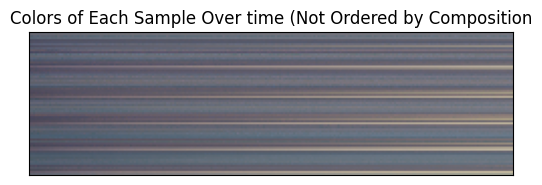

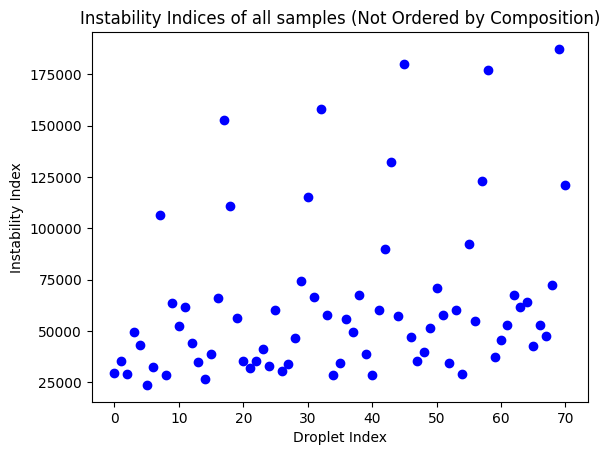

In [14]:
Ic,Test_array_RGB,c = mainfunctions.extract_ic(RGB_result, Number_of_drops,drops,num_pics,verbose=True)

### Section 3: Make All Relevant Figures 

Order the instability indices according to the droplet composition

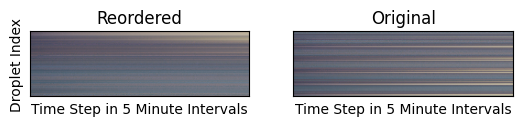

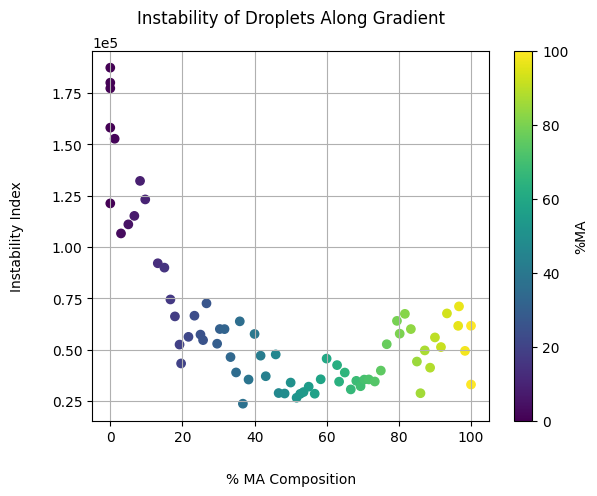

In [15]:
Ic_reorder,Test_array_reorder = mainfunctions.order_ic(Ic, Test_array_RGB,Number_of_drops,drop_IDs,order,comp,verbose=True)

Create Labeled Plot of Sample Colors vs Time. Create GIF of Samples. 

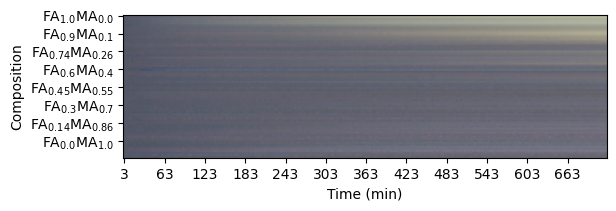

MovieWriter ffmpeg unavailable; using Pillow instead.


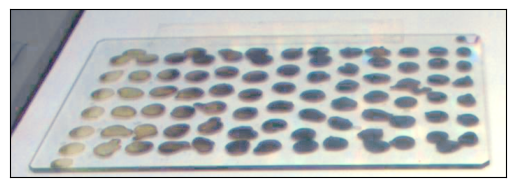

In [16]:
spacing = {
    'y_int' : 10, # Spacing between the y-axis tick marks 
    'x_int' : 20  # Spacing between the x-axis tick marks
} 
mainfunctions.plot_grand(num_pics,Test_array_RGB,Test_array_reorder, time, start_comp, end_comp, comp, Number_of_drops, spacing, verbose=True)
mainfunctions.degrade_gif(num_pics,RGB_result,verbose=True)

Make plots of Individual Droplets Vs Time 

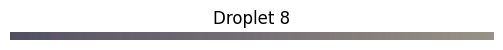

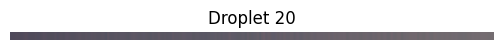

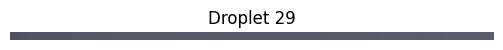

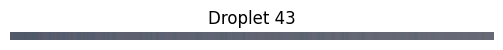

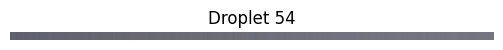

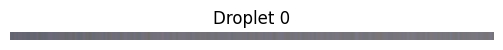

In [17]:
drop_IDs = {
    'desi' : [8,20,29,43,54,0]
}
mainfunctions.individual_drops(c,drop_IDs,Ic_reorder,Test_array_reorder,verbose=True)